In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error, r2_score
plt.rcParams['font.size'] = 16

# Data preparation

In [14]:
elements = pd.read_csv('unique_m.csv')
reduced_ele = elements.loc[:, (elements != 0).any(axis=0)] # select columns containing non-zero elements
reduced_ele = reduced_ele.drop('material', axis = 1)
critical_temp = reduced_ele['critical_temp']
reduced_ele.head()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,Re,Os,Ir,Pt,Au,Hg,Tl,Pb,Bi,critical_temp
0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.0
1,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0
2,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0


In [15]:
dft = pd.read_csv('train.csv')
dft.head()

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [38]:
df = pd.concat([reduced_ele, dft], axis = 1)
df_train = df.drop('critical_temp', axis = 1)
df_train.describe()

,H,Li,Be,B,C,N,O,F,Na,Mg,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
count,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,...,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000,21263.000000
mean,0.017685,0.012125,0.034638,0.142594,0.384968,0.013284,3.009129,0.014874,0.008892,0.026772,...,3.198228,3.153127,3.056536,3.055885,1.295682,1.052841,2.041010,1.483007,0.839342,0.673987
std,0.267220,0.129552,0.848541,1.044486,4.408032,0.150427,3.811649,0.132119,0.101685,0.271606,...,1.044611,1.191249,1.046257,1.174815,0.393155,0.380291,1.242345,0.978176,0.484676,0.455580
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.333333,2.116732,2.279705,2.091251,1.060857,0.775678,1.000000,0.921454,0.451754,0.306892
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,2.833333,2.618182,2.615321,2.434057,1.368922,1.166532,2.000000,1.063077,0.800000,0.500000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.800000,0.000000,0.000000,0.000000,...,4.000000,4.026201,3.727919,3.914868,1.589027,1.330801,3.000000,1.918400,1.200000,1.020436
max,14.000000,3.000000,40.000000,105.000000,120.000000,12.800000,66.000000,4.000000,4.000000,12.000000,...,7.000000,7.000000,7.000000,7.000000,2.141963,1.949739,6.000000,6.992200,3.000000,3.000000


In [28]:
variables = df_train.columns

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, critical_temp, test_size=0.2, random_state=42)

n_train = X_train.shape[0]
n_test = X_test.shape[0]
n_feats = X_train.shape[1]

print('number of observations in training set:', n_train)
print('number of observations in test set:', n_test)
print('number of features:', n_feats)

number of observations in training set: 17010
number of observations in test set: 4253
number of features: 158


In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Default XGBoost

In [31]:
from xgboost import XGBRegressor

xg_model = XGBRegressor(random_state = 1)
xg_model.fit(X_train, y_train)
print("MSE Train:", mean_squared_error(y_train, xg_model.predict(X_train)))
print("MSE Train:", r2_score(y_train, xg_model.predict(X_train)))

MSE Train: 40.64421680593252
MSE Train: 0.9655206975835973


In [70]:
xg_cv = XGBRegressor(random_state = 1)
cross_score = cross_val_score(xg_cv, X_train, y_train, scoring="neg_mean_squared_error", cv = KFold(shuffle=True, random_state=1), n_jobs = -1)
cross_score_r2 = cross_val_score(xg_cv, X_train, y_train, scoring="r2", cv = KFold(shuffle=True, random_state=1), n_jobs = -1)
print(cross_score)
print(cross_score.mean())
print(cross_score_r2)
print(cross_score_r2.mean())

[ -96.60520289  -99.41753844 -104.58073303  -96.86023751  -96.75145875]
-98.8430341246658
[0.91770756 0.91476133 0.91071466 0.91879114 0.91863349]
0.9161216355378137


In [32]:
pred = xg_model.predict(X_test)

In [33]:
print("MSE Test:", mean_squared_error(y_test, pred))
print("MSE Test:", r2_score(y_test, pred))

MSE Test: 85.55215541764711
MSE Test: 0.9256766500328935


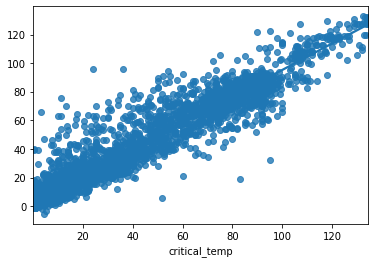

In [34]:
sns.regplot(x = y_test, y = pred)
plt.show()

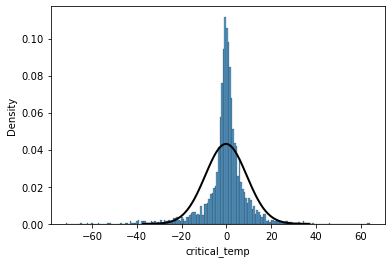

In [35]:
residual = y_test - pred
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

data = residual  
ax = sns.histplot(x=data, stat="density")
normal(data.mean(), data.std()) # a matter of choice: whether I want most being 0 and have large errors on outliers, or if I want to take into account of the outliers

In [36]:
df_y= y_test.to_frame()
df_y['xgb'] = pred
df_y_g = df_y.loc[df_y['critical_temp'] > 77] # use liquid nitrogen as benchmark
df_y_s = df_y.loc[df_y['critical_temp'] <= 77]
#val_y_pred_0 = val_y_pred.loc[val_y_pred['critical_temp'] <= 4]
print(len(df_y_g))
print(len(df_y_s))
print("XGBoost MSE in higher than 77 critical temp", mean_squared_error(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost MSE in lower than 77 critical temp", mean_squared_error(df_y_s['xgb'], df_y_s['critical_temp']))
print("XGBoost R2 in higher than 77 critical temp", r2_score(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost R2 in lower than 77 critical temp", r2_score(df_y_s['xgb'], df_y_s['critical_temp']))

761
3492
XGBoost MSE in higher than 77 critical temp 121.56357044439144
XGBoost MSE in lower than 77 critical temp 77.70430695391504
XGBoost R2 in higher than 77 critical temp 0.47630704803579993
XGBoost R2 in lower than 77 critical temp 0.8479447552044385


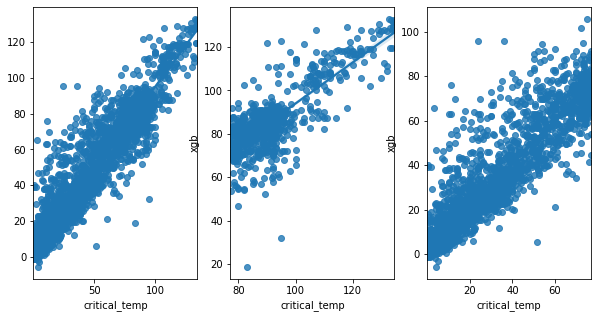

In [37]:
fig, axes = plt.subplots(1,3, figsize = (10,5))
ax1 = axes[0]
sns.regplot(ax = ax1, x = y_test, y = pred)
ax2 = axes[1]
sns.regplot(ax = ax2, x = df_y_g['critical_temp'], y = df_y_g['xgb'])
ax3 = axes[2]
sns.regplot(ax = ax3, x = df_y_s['critical_temp'], y = df_y_s['xgb'])
plt.show()

# Hyperparameter Tuning

In [39]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 0,5),
       'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,15),
        'reg_lambda' : hp.uniform('reg_lambda', 0,3),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.3, 1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
        'n_estimators': hp.quniform('n_estimators', 100,600, 1)
    }

In [49]:
def objective(space):
    xg_model = XGBRegressor(
                    n_estimators = int(space['n_estimators']), max_depth = int(space['max_depth']), gamma = space['gamma'],
                    learning_rate = space['learning_rate'], reg_alpha = space['reg_alpha'],min_child_weight=space['min_child_weight'],
                    colsample_bytree=int(space['colsample_bytree']), random_state = 1, eval_metric = 'rmse')
    #cross_score = cross_val_score(xg_model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()
    cross_score = cross_val_score(xg_model, X_train, y_train, scoring="neg_mean_squared_error", cv = KFold(shuffle=True, random_state=1), n_jobs = -1).mean()
    print("MSE SCORE:", cross_score)
    return {'loss': -cross_score, 'status': STATUS_OK}

In [52]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

MSE SCORE:                                             
-172.06965354623952                                    
MSE SCORE:                                                                       
-179.87232506747355                                                              
MSE SCORE:                                                                       
-180.3310452152792                                                               
MSE SCORE:                                                                       
-157.69992967024194                                                              
MSE SCORE:                                                                       
-155.63742807394036                                                              
MSE SCORE:                                                                       
-245.21499743692374                                                              
MSE SCORE:                                                          

### Problems
I am very confused as why the CV score for the default XGB is better (MSE below 100) than after tuning with hyperopt. I will return to Randomized CV combined with GridSearch CV.

## Hyperparameter Tuning -- Randomized

In [63]:
params = {
 "n_estimators": [50 * i for i in range(2, 11)],
 "learning_rate" : [0.05 * i for i in range(1,21)], # default 0.3
 "max_depth" : [i for i in range(4, 18)], # default 6
 "min_child_weight" : [1, 2, 3, 4, 5, 6, 7 ,8, 9, 10], # default = 1, the greater the more conservative
 "gamma": [0.1 * i for i in range(101)], # control how conservative the model is, default = 0, the greater gamma, the more conservative
 "colsample_bytree" : [ 0.1 * i for i in range(1, 11)] # default = 1. the subsample ratio of columns for each tree. Subsampling occurs once for every tree constructed
}

In [64]:
xg_model = XGBRegressor(random_state = 1, eval_metric = 'rmse')
xg_tuning=RandomizedSearchCV(xg_model,param_distributions= params,scoring = 'neg_mean_squared_error',n_iter=200, n_jobs=-1,cv=5,verbose=3)
xg_tuning.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          eval_metric='rmse', gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None...
                                                          0.2, 0.25,
                                                          0.30000000000000004,
                                           

In [65]:
xg_tuning.best_score_

-87.02257992995615

In [66]:
xg_tuning.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.30000000000000004,
             eval_metric='rmse', gamma=1.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [72]:
xg_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.30000000000000004,
             eval_metric='rmse', gamma=1.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=5,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [69]:
cross_score = cross_val_score(xg_model, X_train, y_train, scoring="neg_mean_squared_error", cv = KFold(shuffle=True, random_state=1), n_jobs = -1)
cross_score_r2 = cross_val_score(xg_model, X_train, y_train, scoring="r2", cv = KFold(shuffle=True, random_state=1), n_jobs = -1)
print(cross_score)
print(cross_score.mean())
print(cross_score_r2)
print(cross_score_r2.mean())

[-86.59494028 -90.33188335 -92.95389907 -88.67261178 -85.27973052]
-88.76661300159905
[0.92623473 0.92255119 0.92064102 0.92565575 0.92828104]
0.9246727459477224


In [71]:
xg_cv_results = pd.DataFrame.from_dict(xg_tuning.cv_results_)
xg_cv_results.sort_values(by=['rank_test_score']).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_child_weight,param_max_depth,param_learning_rate,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
193,39.875214,1.157697,0.155621,0.019791,300,5,12,0.05,1.6,0.3,"{'n_estimators': 300, 'min_child_weight': 5, '...",-94.881219,-87.531553,-77.886885,-93.852153,-80.961090,-87.022580,6.765544,1
97,56.793391,1.987314,0.226696,0.023437,500,1,10,0.05,2.4,0.3,"{'n_estimators': 500, 'min_child_weight': 1, '...",-96.407759,-85.003603,-79.608664,-93.121515,-81.253940,-87.079096,6.596700,2
73,84.393620,0.313847,0.387611,0.071511,400,3,14,0.05,7.8,0.4,"{'n_estimators': 400, 'min_child_weight': 3, '...",-96.357714,-85.343718,-78.683768,-96.215069,-79.380299,-87.196113,7.775022,3
137,35.853533,0.974570,0.099821,0.011027,250,8,10,0.05,7.0,0.4,"{'n_estimators': 250, 'min_child_weight': 8, '...",-92.671087,-87.215439,-79.116756,-95.464839,-82.448509,-87.383326,6.098984,4
156,72.642525,0.383036,0.202242,0.032929,350,3,12,0.05,4.5,0.5,"{'n_estimators': 350, 'min_child_weight': 3, '...",-97.443683,-85.853103,-79.503615,-95.641358,-79.211370,-87.530626,7.752544,5


## Test

In [73]:
xg_model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.30000000000000004,
             eval_metric='rmse', gamma=1.6, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=12, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, random_state=1, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [76]:
pred = xg_model.predict(X_test)
print("MSE Test:", mean_squared_error(y_test, pred))
print("R2 Test:", r2_score(y_test, pred))

MSE Test: 74.6982407510434
R2 Test: 0.9351059776090481


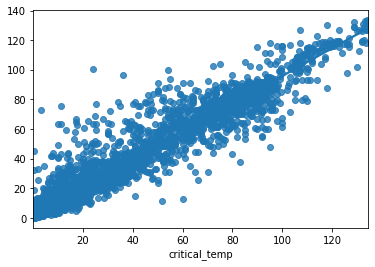

In [77]:
sns.regplot(x = y_test, y = pred)
plt.show()

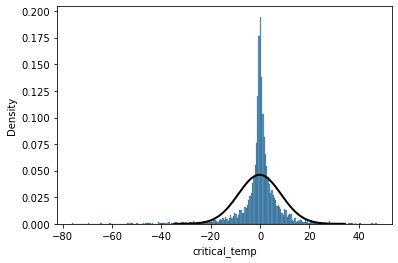

In [78]:
residual = y_test - pred

data = residual  
ax = sns.histplot(x=data, stat="density")
normal(data.mean(), data.std()) 

In [79]:
df_y= y_test.to_frame()
df_y['xgb'] = pred
df_y_g = df_y.loc[df_y['critical_temp'] > 77] # use liquid nitrogen as benchmark
df_y_s = df_y.loc[df_y['critical_temp'] <= 77]
#val_y_pred_0 = val_y_pred.loc[val_y_pred['critical_temp'] <= 4]
print(len(df_y_g))
print(len(df_y_s))
print("XGBoost MSE in higher than 77 critical temp", mean_squared_error(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost MSE in lower than 77 critical temp", mean_squared_error(df_y_s['xgb'], df_y_s['critical_temp']))
print("XGBoost R2 in higher than 77 critical temp", r2_score(df_y_g['xgb'], df_y_g['critical_temp']))
print("XGBoost R2 in lower than 77 critical temp", r2_score(df_y_s['xgb'], df_y_s['critical_temp']))

761
3492
XGBoost MSE in higher than 77 critical temp 98.46565223196008
XGBoost MSE in lower than 77 critical temp 69.51868744721247
XGBoost R2 in higher than 77 critical temp 0.5428420694685807
XGBoost R2 in lower than 77 critical temp 0.8629203790196343


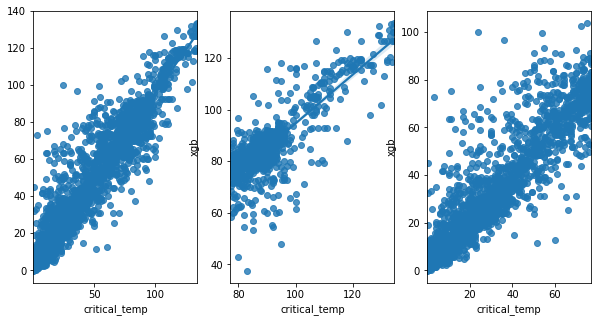

In [80]:
fig, axes = plt.subplots(1,3, figsize = (10,5))
ax1 = axes[0]
sns.regplot(ax = ax1, x = y_test, y = pred)
ax2 = axes[1]
sns.regplot(ax = ax2, x = df_y_g['critical_temp'], y = df_y_g['xgb'])
ax3 = axes[2]
sns.regplot(ax = ax3, x = df_y_s['critical_temp'], y = df_y_s['xgb'])
plt.show()

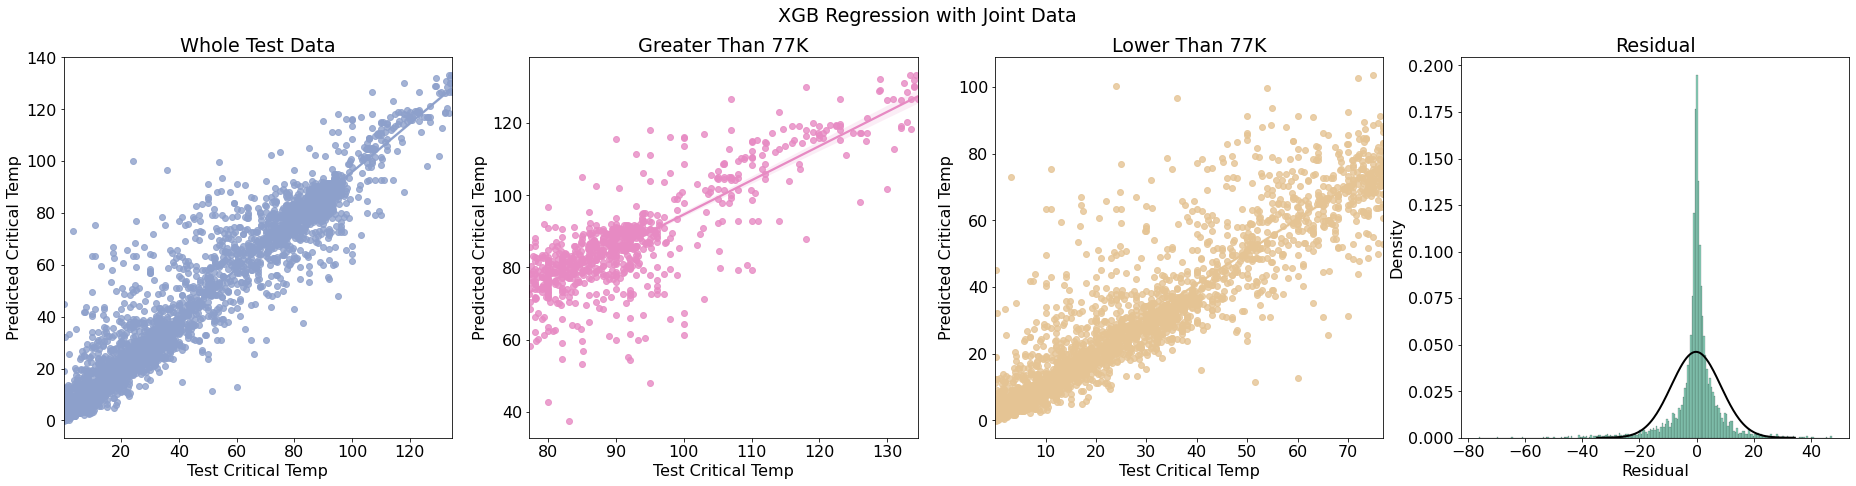

In [89]:
fig, axes = plt.subplots(1,4, figsize = (32,7))
ax1 = axes[0]
sns.regplot(ax = ax1, x = y_test, y = pred, color = sns.color_palette("Set2")[2])
ax1.set_xlabel('Test Critical Temp')
ax1.set_ylabel('Predicted Critical Temp')
ax1.set_title('Whole Test Data')
ax2 = axes[1]
sns.regplot(ax = ax2, x = df_y_g['critical_temp'], y = df_y_g['xgb'], color = sns.color_palette("Set2")[3])
ax2.set_xlabel('Test Critical Temp')
ax2.set_ylabel('Predicted Critical Temp')
ax2.set_title('Greater Than 77K')
ax3 = axes[2]
sns.regplot(ax = ax3, x = df_y_s['critical_temp'], y = df_y_s['xgb'], color = sns.color_palette("Set2")[6])
ax3.set_xlabel('Test Critical Temp')
ax3.set_ylabel('Predicted Critical Temp')
ax3.set_title('Lower Than 77K')
ax4 = axes[3]
sns.histplot(ax = ax4, x=data, stat="density", color = sns.color_palette("Set2")[0])
normal(data.mean(), data.std()) 
ax4.set_title('Residual')
ax4.set_xlabel('Residual')
ax4.set_ylabel('Density')
fig.suptitle('XGB Regression')
fig.suptitle('XGB Regression with Joint Data')
plt.savefig('xgb_joint_tp.pdf', bbox_inches = 'tight')

In [130]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.size'] = 16

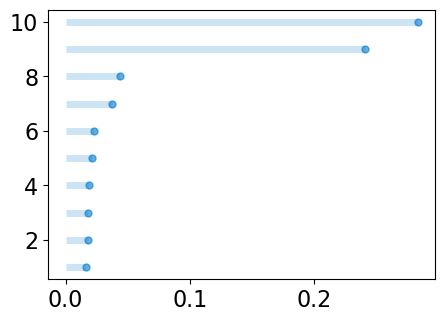

In [131]:
import xgboost
my_range=list(range(1,11))
sorted_idx = xg_model.feature_importances_.argsort()
fig, ax = plt.subplots(figsize=(5,3.5))
plt.hlines(y=my_range, xmin=0, xmax=xg_model.feature_importances_[sorted_idx][-10:], color='#007ACC', alpha=0.2, linewidth=5)
plt.plot(xg_model.feature_importances_[sorted_idx][-10:], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)
#plt.barh(df_train.columns[sorted_idx][-10:], xg_model.feature_importances_[sorted_idx][-10:])
plt.show()

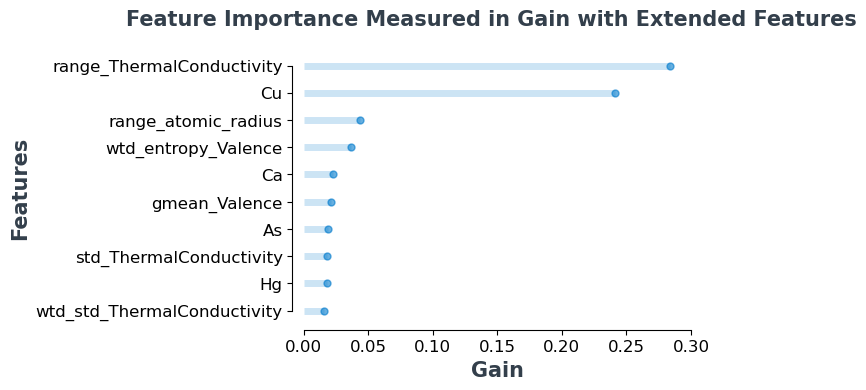

In [134]:

my_range=list(range(1,11))

fig, ax = plt.subplots(figsize=(5,3.5))

plt.hlines(y=my_range, xmin=0, xmax=xg_model.feature_importances_[sorted_idx][-10:], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(xg_model.feature_importances_[sorted_idx][-10:], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Gain', fontsize=15, fontweight='black', color = '#333F4B')
ax.set_ylabel('Features',fontsize=15, fontweight='black', color = '#333F4B')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, df_train.columns[sorted_idx][-10:])

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'Feature Importance Measured in Gain with Extended Features', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0,0.3)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))
plt.savefig('xgb_j_fi.pdf', bbox_inches = 'tight')